# Load des données d'après le notebook démo

In [1]:
# Load packages and classes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tiffslide
import seaborn as sns
import gget
import tifffile
import zarr

# MosaicDataset and BruceDataset classes allow loading and visualisation of the different data sources
from gbmhackathon import MosaicDataset, BruceDataset

In [2]:
# Look at the available data sources
MosaicDataset.sources.keys()

dict_keys(['clinical', 'bulk_rna', 'spatial', 'sc_rna', 'wes', 'he'])

In [3]:
# The following cell will returns a dictionary with the data sources in the
# keys and the list of files (and path) used to return the data.
source_dict_mosaic = MosaicDataset.load_tabular()

In [4]:
filename_sample_table = "/home/ec2-user/SageMaker/data/mosaic_dataset/Data availibility per modality per patient.csv"
sample_table = pd.read_csv(filename_sample_table, index_col=0)
sample_table.head(2)

,Visium_usable,WES_usable,scRNAseq_usable,bulkRNAseq_usable,HE_usable,Clinical_usable
Hackathon_ID,,,,,,
HK_G_001a,Yes,Yes,Yes,Yes,Yes,Yes
HK_G_002a,Yes,Yes,Yes,Yes,Yes,Yes


In [5]:
#recurrent_full_usable_ids = [idx for idx in list(sample_table[np.sum(sample_table == 'Yes', axis=1) == 6].index) if idx.endswith("b")]
#primary_full_usable_ids = [idx for idx in list(sample_table[np.sum(sample_table == 'Yes', axis=1) == 6].index) if idx.endswith("a")]
#primary_full_usable_ids
#roots_recurrent = list(map(lambda x: x[:-1], recurrent_full_usable_ids))
#roots_primary = list(map(lambda x: x[:-1], primary_full_usable_ids))
#print(roots_recurrent)
#print("Common")
#for 
#common = [idx for idx in roots_primary if idx in roots_recurrent]
#common

In [6]:
gbm_df = source_dict_mosaic["clinical"]["processed gbm clinical"]
treatment_df = source_dict_mosaic["clinical"]["treatments"]
event_df = source_dict_mosaic["clinical"]["key events clinical"]

## Correction des valeurs erronées reportées dans le slack

In [7]:
def identify_sample_id(sample_id):
    if sample_id.endswith("b"):
        return True
    else:
        return False
recurrent_samples_mask = gbm_df.index.map(identify_sample_id)
recurrent_samples = gbm_df[recurrent_samples_mask]
primary_samples = gbm_df[~recurrent_samples_mask]

In [8]:
print(f"\nTotal n_rows {gbm_df.shape[0]}, Recurrent ({recurrent_samples.shape[0]}) + Primary ({primary_samples.shape[0]}) = ({recurrent_samples.shape[0] + primary_samples.shape[0]})")


Total n_rows 114, Recurrent (20) + Primary (94) = (114)


In [9]:
root_recurrent_id = recurrent_samples.index.map(lambda x: x[:-1])
root_recurrent_id

Index(['HK_G_017', 'HK_G_029', 'HK_G_036', 'HK_G_044', 'HK_G_059', 'HK_G_061',
       'HK_G_079', 'HK_G_082', 'HK_G_084', 'HK_G_086', 'HK_G_090', 'HK_G_092',
       'HK_G_096', 'HK_G_098', 'HK_G_100', 'HK_G_105', 'HK_G_109', 'HK_G_111',
       'HK_G_113', 'HK_G_115'],
      dtype='object', name='sample_id')

In [10]:
years_col = [col for col in gbm_df.columns if col.endswith("_years")]
years_col.remove('time_interval_sample_harvest_dearchival_years')
years_col

['smoking_quantity_pack_years',
 'os_years',
 'pfs_years',
 'age_at_diagnosis_years']

In [11]:
primary_samples.index.value_counts()

sample_id
HK_G_001a    1
HK_G_066a    1
HK_G_075a    1
HK_G_074a    1
HK_G_073a    1
            ..
HK_G_032a    1
HK_G_031a    1
HK_G_030a    1
HK_G_028a    1
HK_G_114a    1
Name: count, Length: 94, dtype: int64

In [12]:
weird_ids = []

for sample_id in primary_samples.index:
    # Extract root ID and number part
    root = sample_id[:-4]  # Everything before the last three characters
    digits = sample_id[-4:-1]  # Extract last two numerical digits
    suffix = sample_id[-1]  # Last character (e.g., "a" or "b")
    print(digits)
    # Compute the paired recurrent ID
    recurrent_digit = f"{int(digits) + 1:03d}"  # Ensure it is zero-padded to 2 digits
    #print(recurrent_digit)
    paired_id = root + recurrent_digit + ("b" if suffix == "a" else "a")
    #print(paired_id)
    if paired_id in recurrent_samples.index:
        print(sample_id)
        print(paired_id)
        for col in years_col:
            #print()
            primary_value = primary_samples.loc[sample_id, col]
            recurrent_value = recurrent_samples.loc[paired_id, col]
            print(f"\nFor col : {col}")
            print(f"Primary {primary_value}")
            print(f"Recurrent {recurrent_value}")
            if primary_value > recurrent_value:
                root_id = sample_id[:-1]  # Strip "a" or "b" suffix
                if root_id not in weird_ids:
                    weird_ids.append(root_id)
len(weird_ids)

001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
HK_G_016a
HK_G_017b

For col : smoking_quantity_pack_years
Primary nan
Recurrent nan

For col : os_years
Primary 1.2895277207392195
Recurrent 1.2895277207392195

For col : pfs_years
Primary 0.4955509924709103
Recurrent 0.4955509924709103

For col : age_at_diagnosis_years
Primary 67.84756064173466
Recurrent 67.84756064173466
018
019
020
021
022
023
024
025
026
027
028
HK_G_028a
HK_G_029b

For col : smoking_quantity_pack_years
Primary nan
Recurrent nan

For col : os_years
Primary 4.509240246406571
Recurrent 4.509240246406571

For col : pfs_years
Primary 1.1143052703627652
Recurrent 1.1143052703627652

For col : age_at_diagnosis_years
Primary 65.76685101023928
Recurrent 65.76685101023928
030
031
032
033
034
035
HK_G_035a
HK_G_036b

For col : smoking_quantity_pack_years
Primary nan
Recurrent nan

For col : os_years
Primary 1.9876796714579053
Recurrent 1.9876796714579053

For col : pfs_years
Primary 0.298425735797399
Recurrent 

0

Correction de l'id identifié dans le slack (HK_G_81a)

In [13]:
primary_samples.at["HK_G_081a","pfs_years"] = 0.6974674880219027
primary_samples.loc["HK_G_081a"]["pfs_years"]

0.6974674880219027

## Correction des IDs

In [14]:
import re

def correct_patient_id(sample_id):
    match = re.match(r"(.*)b$", sample_id)
    if match:
        base_id = match.group(1)  # remove "b"
        numeric_part = re.search(r"(\d+)", base_id)  # extract numeric part
        if numeric_part:
            num_str = numeric_part.group(0)
            new_num = str(int(num_str) - 1).zfill(len(num_str))
            corrected_id = base_id.replace(num_str, new_num)
            return corrected_id
    return sample_id[:-1]  # remove last letter for "a" samples
    
gbm_df["corrected_patient_id"] = gbm_df.index.map(correct_patient_id)

In [15]:
gbm_df["patient_id"].value_counts()

patient_id
HK_G_001    1
HK_G_086    1
HK_G_084    1
HK_G_083    1
HK_G_082    1
           ..
HK_G_035    1
HK_G_034    1
HK_G_033    1
HK_G_032    1
HK_G_115    1
Name: count, Length: 114, dtype: int64

In [16]:
gbm_df["corrected_patient_id"].value_counts()

corrected_patient_id
HK_G_114    2
HK_G_095    2
HK_G_028    2
HK_G_078    2
HK_G_081    2
           ..
HK_G_033    1
HK_G_032    1
HK_G_031    1
HK_G_030    1
HK_G_052    1
Name: count, Length: 95, dtype: int64

## Stockage des données de rechutes ou non

In [17]:
gbm_df.columns

Index(['patient_id', 'cohort_code', 'cancer_indication', 'sample_source',
       'sample_origin', 'sample_collection_chronology',
       'administrative_gender', 'smoking_status',
       'smoking_quantity_pack_years', 'alcohol_intake', 'os_years',
       'os_censor', 'pfs_years', 'pfs_censor', 'age_at_diagnosis_years',
       'primary_tumour_side', 'number_of_brain_tumour_sites',
       'largest_diameter_of_the_primary_tumour_mm_duplicated_0',
       'surgery_type', 'tumour_resection_chronology',
       'microvascular_proliferation', 'necrosis', 'presence_of_small_cells',
       'atrx_loss_of_expression_ihc', 'atrx_mutation', 'braf_mutation', 'gfap',
       'olig2', 'p53', 'idh1_idh2_mutation', 'idh1_r132h_expression_ihc',
       'tert_promoter_mutation', 'mgmt_promoter_methylation', 'egfr_mutation',
       'egfr_amplification', 'pten_mutation', 'ntrk_fusion',
       'histone_h3_g34_mutation_sequencing',
       'histone_h3_k27m_mutation_sequencing',
       'time_interval_sample_harvest

In [18]:
def get_recurrent_info(sample_id):
    if sample_id.endswith("b"):
        return 1
    else:
        return 0

In [19]:
gbm_df["old_patient_id"] = gbm_df.index
gbm_df["old_patient_id"]

sample_id
HK_G_001a    HK_G_001a
HK_G_002a    HK_G_002a
HK_G_003a    HK_G_003a
HK_G_004a    HK_G_004a
HK_G_005a    HK_G_005a
               ...    
HK_G_111b    HK_G_111b
HK_G_112a    HK_G_112a
HK_G_113b    HK_G_113b
HK_G_114a    HK_G_114a
HK_G_115b    HK_G_115b
Name: old_patient_id, Length: 114, dtype: object

In [20]:
gbm_df["recurrent_sample"] = gbm_df["old_patient_id"].map(get_recurrent_info)
gbm_df["recurrent_sample"].value_counts()

recurrent_sample
0    94
1    20
Name: count, dtype: int64

## Séparation des données "Target"

In [21]:
NUM_TARGETS = ["os_years", "pfs_years", "largest_diameter_of_the_primary_tumour_mm_duplicated_0"] # TASK : Predict values
CAT_TARGET = ["recurrent_sample"] # TASK : Is this a recurring sample
TARGETS = NUM_TARGETS + CAT_TARGET

In [22]:
cat_features = []
for col in gbm_df.columns:
    if gbm_df[col].value_counts().shape[0] <= 10:
        cat_features.append(col)
        print(f"\nFor {col} column")
        print(gbm_df[col].value_counts())
        print(np.sum(pd.isna(gbm_df[col])))
print(f"\nTotal {len(cat_features)} columns")


For cohort_code column
cohort_code
HK_GBM_#1    114
Name: count, dtype: int64
0

For cancer_indication column
cancer_indication
G: Glioblastoma    114
Name: count, dtype: int64
0

For sample_source column
sample_source
Surgical specimen    112
Biopsy                 2
Name: count, dtype: int64
0

For sample_origin column
sample_origin
Primary tumour    114
Name: count, dtype: int64
0

For sample_collection_chronology column
sample_collection_chronology
Baseline         95
At recurrence    19
Name: count, dtype: int64
0

For administrative_gender column
administrative_gender
Male      71
Female    43
Name: count, dtype: int64
0

For smoking_status column
smoking_status
Non smoker       14
Former smoker    11
Active smoker     4
Name: count, dtype: int64
85

For smoking_quantity_pack_years column
smoking_quantity_pack_years
14.0    1
64.0    1
10.0    1
80.0    1
Name: count, dtype: int64
110

For alcohol_intake column
alcohol_intake
Active drinker    10
Non drinker        8
Former drin

In [23]:
not_features = ["cohort_code", "cancer_indication", "sample_source", "sample_origin", "tumour_resection_chronology"]
cat_features = [col for col in cat_features if col not in not_features]
num_features = [col for col in gbm_df.columns if col not in cat_features and col not in not_features]

In [24]:
cat_features

['sample_collection_chronology',
 'administrative_gender',
 'smoking_status',
 'smoking_quantity_pack_years',
 'alcohol_intake',
 'os_censor',
 'pfs_censor',
 'primary_tumour_side',
 'number_of_brain_tumour_sites',
 'surgery_type',
 'microvascular_proliferation',
 'necrosis',
 'presence_of_small_cells',
 'atrx_loss_of_expression_ihc',
 'atrx_mutation',
 'braf_mutation',
 'gfap',
 'olig2',
 'p53',
 'idh1_idh2_mutation',
 'idh1_r132h_expression_ihc',
 'tert_promoter_mutation',
 'mgmt_promoter_methylation',
 'egfr_mutation',
 'egfr_amplification',
 'pten_mutation',
 'ntrk_fusion',
 'histone_h3_g34_mutation_sequencing',
 'histone_h3_k27m_mutation_sequencing',
 'recurrent_sample']

In [25]:
true_cat_features = [col for col in cat_features if col not in TARGETS]

In [26]:
cat_gbm_df = gbm_df[true_cat_features]
cat_gbm_df.shape

(114, 29)

In [27]:
cat_gbm_df = cat_gbm_df.fillna(value="Unk")
np.sum(pd.isna(cat_gbm_df))

/home/ec2-user/SageMaker/.conda/envs/gbmhackathon/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


sample_collection_chronology           0
administrative_gender                  0
smoking_status                         0
smoking_quantity_pack_years            0
alcohol_intake                         0
os_censor                              0
pfs_censor                             0
primary_tumour_side                    0
number_of_brain_tumour_sites           0
surgery_type                           0
microvascular_proliferation            0
necrosis                               0
presence_of_small_cells                0
atrx_loss_of_expression_ihc            0
atrx_mutation                          0
braf_mutation                          0
gfap                                   0
olig2                                  0
p53                                    0
idh1_idh2_mutation                     0
idh1_r132h_expression_ihc              0
tert_promoter_mutation                 0
mgmt_promoter_methylation              0
egfr_mutation                          0
egfr_amplificati

Recuperation des données numériques

In [28]:
# On a plus besoin des deux colonnes ci dessous
num_features.remove('corrected_patient_id')
num_features.remove('old_patient_id')

In [29]:
num_gbm_df = gbm_df[num_features]

In [30]:
num_gbm_df.columns

Index(['patient_id', 'os_years', 'pfs_years', 'age_at_diagnosis_years',
       'largest_diameter_of_the_primary_tumour_mm_duplicated_0',
       'time_interval_sample_harvest_dearchival_years'],
      dtype='object')

In [31]:
true_num_features = [col for col in num_features if col != 'patient_id' and col not in TARGETS]
true_num_features

['age_at_diagnosis_years', 'time_interval_sample_harvest_dearchival_years']

In [32]:
np.sum(pd.isna(num_gbm_df), axis=1)

sample_id
HK_G_001a    0
HK_G_002a    0
HK_G_003a    1
HK_G_004a    0
HK_G_005a    0
            ..
HK_G_111b    0
HK_G_112a    0
HK_G_113b    0
HK_G_114a    0
HK_G_115b    0
Length: 114, dtype: int64

In [33]:
from sklearn.impute import KNNImputer
knn = KNNImputer()

imputed_num_gbm_df = pd.DataFrame(knn.fit_transform(num_gbm_df[true_num_features]), columns=true_num_features, index=num_gbm_df.index)

In [34]:
np.sum(pd.isna(imputed_num_gbm_df), axis=1)

sample_id
HK_G_001a    0
HK_G_002a    0
HK_G_003a    0
HK_G_004a    0
HK_G_005a    0
            ..
HK_G_111b    0
HK_G_112a    0
HK_G_113b    0
HK_G_114a    0
HK_G_115b    0
Length: 114, dtype: int64

In [35]:
np.sum(pd.isna(imputed_num_gbm_df))

/home/ec2-user/SageMaker/.conda/envs/gbmhackathon/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


age_at_diagnosis_years                           0
time_interval_sample_harvest_dearchival_years    0
dtype: int64

### Les données sont presque cleans

## MCA sur données catégorielles

In [36]:
!pip install prince

                 0         1         2         3         4         5   \
sample_id                                                               
HK_G_001a -0.122711 -0.066547  0.118886 -0.074680 -0.237562 -0.048309   
HK_G_002a  0.036260 -0.366782 -0.619370 -0.884231  0.525237 -0.744937   
HK_G_003a -0.149284 -0.360918  0.210512 -0.029924 -0.094059 -0.386606   
HK_G_004a -0.128475 -0.311660  0.100755 -0.016637  0.010285 -0.147883   
HK_G_005a -0.061068 -0.170790 -0.180256 -0.150183  0.118583  0.084855   

                 6         7         8         9   ...        40        41  \
sample_id                                          ...                       
HK_G_001a -0.017559 -0.053012  0.042607  0.178432  ... -0.063234  0.168918   
HK_G_002a  0.825076 -0.315661  0.067046  0.129586  ... -0.015611 -0.001500   
HK_G_003a -0.034638  0.160792 -0.096212 -0.029407  ...  0.003818  0.005348   
HK_G_004a -0.019071  0.422177  0.169434  0.000359  ...  0.024708  0.002142   
HK_G_005a  0.154434 

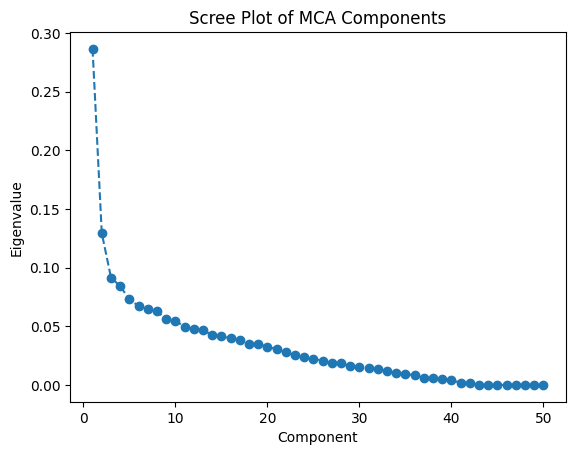

In [37]:
import prince
import matplotlib.pyplot as plt

# Ensure all columns are categorical
df = cat_gbm_df.astype('category')

# Initialize MCA
mca = prince.MCA(n_components=50, n_iter=3, copy=True, random_state=42)

# Fit MCA on the categorical dataframe
mca_results = mca.fit(df)

# Get transformed coordinates of individuals (rows)
mca_coordinates = mca.transform(df)

# Display the top rows of MCA components
print(mca_coordinates.head())

# Get eigenvalues (variance explained per component)
eigenvalues = mca.eigenvalues_

# Plot the scree plot
plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, marker='o', linestyle='--')
plt.xlabel("Component")
plt.ylabel("Eigenvalue")
plt.title("Scree Plot of MCA Components")
plt.show()

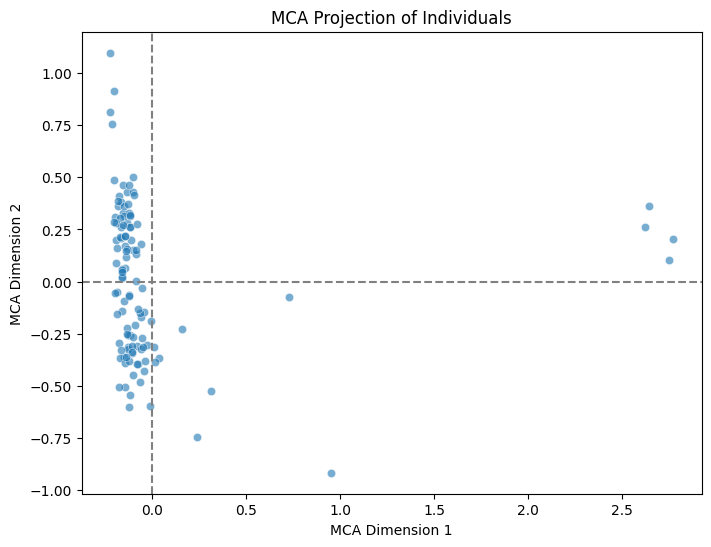

In [38]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=mca_coordinates.iloc[:,0], y=mca_coordinates.iloc[:,1], alpha=0.6)
plt.xlabel("MCA Dimension 1")
plt.ylabel("MCA Dimension 2")
plt.title("MCA Projection of Individuals")
plt.axhline(0, color='gray', linestyle='dashed')
plt.axvline(0, color='gray', linestyle='dashed')
plt.show()

### Prenons les 10 premières dimensions de la MCA

In [39]:
mca_gbm_df = mca_coordinates.iloc[:,:10]
mca_gbm_df.columns = [f"MCA{i}" for i in range(10)]
mca_gbm_df.index = df.index
mca_gbm_df.head()

,MCA0,MCA1,MCA2,MCA3,MCA4,MCA5,MCA6,MCA7,MCA8,MCA9
sample_id,,,,,,,,,,
HK_G_001a,-0.122711,-0.066547,0.118886,-0.074680,-0.237562,-0.048309,-0.017559,-0.053012,0.042607,0.178432
HK_G_002a,0.036260,-0.366782,-0.619370,-0.884231,0.525237,-0.744937,0.825076,-0.315661,0.067046,0.129586
HK_G_003a,-0.149284,-0.360918,0.210512,-0.029924,-0.094059,-0.386606,-0.034638,0.160792,-0.096212,-0.029407
HK_G_004a,-0.128475,-0.311660,0.100755,-0.016637,0.010285,-0.147883,-0.019071,0.422177,0.169434,0.000359
HK_G_005a,-0.061068,-0.170790,-0.180256,-0.150183,0.118583,0.084855,0.154434,-0.090906,0.098390,0.069909


## Normalisation des données

In [40]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
norm_num_gbm_df = pd.DataFrame(scaler.fit_transform(imputed_num_gbm_df), columns=imputed_num_gbm_df.columns, index=imputed_num_gbm_df.index)
norm_num_gbm_df.head()

,age_at_diagnosis_years,time_interval_sample_harvest_dearchival_years
sample_id,,
HK_G_001a,0.126483,0.993463
HK_G_002a,-2.702215,0.732828
HK_G_003a,-0.965822,0.550500
HK_G_004a,-1.145326,0.465180
HK_G_005a,-0.651280,0.056111


## UMAP des embeddings cliniques

In [41]:
complete_df = norm_num_gbm_df.join(mca_gbm_df)
complete_df

,age_at_diagnosis_years,time_interval_sample_harvest_dearchival_years,MCA0,MCA1,MCA2,MCA3,MCA4,MCA5,MCA6,MCA7,MCA8,MCA9
sample_id,,,,,,,,,,,,
HK_G_001a,0.126483,0.993463,-0.122711,-0.066547,0.118886,-0.074680,-0.237562,-0.048309,-0.017559,-0.053012,0.042607,0.178432
HK_G_002a,-2.702215,0.732828,0.036260,-0.366782,-0.619370,-0.884231,0.525237,-0.744937,0.825076,-0.315661,0.067046,0.129586
HK_G_003a,-0.965822,0.550500,-0.149284,-0.360918,0.210512,-0.029924,-0.094059,-0.386606,-0.034638,0.160792,-0.096212,-0.029407
HK_G_004a,-1.145326,0.465180,-0.128475,-0.311660,0.100755,-0.016637,0.010285,-0.147883,-0.019071,0.422177,0.169434,0.000359
HK_G_005a,-0.651280,0.056111,-0.061068,-0.170790,-0.180256,-0.150183,0.118583,0.084855,0.154434,-0.090906,0.098390,0.069909
...,...,...,...,...,...,...,...,...,...,...,...,...
HK_G_111b,0.520411,0.669714,-0.119486,0.317843,-0.229980,0.112589,-0.105383,0.134012,0.073561,-0.003851,-0.048375,0.086250
HK_G_112a,-0.942633,-0.328413,-0.203279,0.283621,-0.419904,-0.112949,0.209903,-0.347922,0.304728,0.490195,-0.038272,0.077306
HK_G_113b,-0.942633,-1.284465,-0.179328,0.384214,-0.509406,-0.062875,0.229633,-0.341516,0.281202,0.528619,-0.027429,0.057525


In [42]:
complete_df.to_csv("~/SageMaker/gbm_hackathon/notebooks/Clinical_Data/clinical_emb.csv")

## Targets 

In [43]:
knn_targets = KNNImputer()

target_df = gbm_df[TARGETS]
imputed_targets_df = pd.DataFrame(knn_targets.fit_transform(target_df), columns=target_df.columns, index=target_df.index)
imputed_targets_df

,os_years,pfs_years,largest_diameter_of_the_primary_tumour_mm_duplicated_0,recurrent_sample
sample_id,,,,
HK_G_001a,1.489391,1.489391,42.0,0.0
HK_G_002a,2.420260,1.702943,46.0,0.0
HK_G_003a,1.749487,0.936345,40.0,0.0
HK_G_004a,1.166324,0.260096,29.0,0.0
HK_G_005a,3.334702,0.068446,48.0,0.0
...,...,...,...,...
HK_G_111b,2.203970,0.670773,25.0,1.0
HK_G_112a,3.019849,2.190281,38.0,0.0
HK_G_113b,3.019849,2.190281,38.0,1.0


In [44]:
imputed_targets_df.to_csv("~/SageMaker/gbm_hackathon/notebooks/Clinical_Data/targets.csv")

## UMAP ?

In [45]:
!pip install umap-learn

In [46]:
import umap

umap_model = umap.UMAP(n_components=2, random_state=42)
embedding = umap_model.fit_transform(complete_df)

# Convertir en DataFrame pour analyse
df_umap = pd.DataFrame(embedding, columns=['UMAP_1', 'UMAP_2'])

/home/ec2-user/SageMaker/.conda/envs/gbmhackathon/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


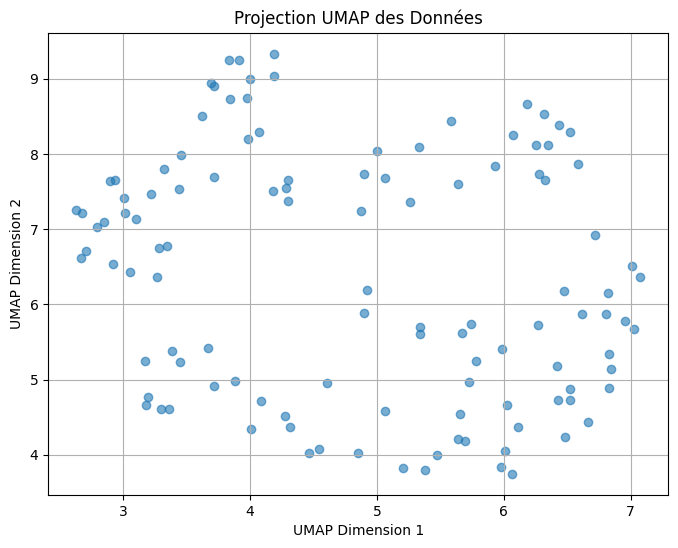

In [47]:
plt.figure(figsize=(8,6))
plt.scatter(df_umap["UMAP_1"], df_umap["UMAP_2"], alpha=0.6)
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.title("Projection UMAP des Données")
plt.grid(True)
plt.show()